In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox 
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch, Circle
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs
import cartopy as ctp
from cmcrameri import cm
import ee
import geemap
import numpy as np
import json

In [2]:
# # # Trigger the authentication flow.
# ee.Authenticate()

# # # Initialize the library.
ee.Initialize()

In [3]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_plotting = os.path.join(folder_HMA, 'Plotting')
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')

# open rgi
path_rgi = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_full_rgi.shp")
path_dc = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_dc_rgi.shp")
rgi_gdf = gpd.read_file(path_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(path_dc).to_crs("ESRI:102025")

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

In [4]:
# define the Asia_North_Albers_Equal_Area_Conic projection to be used to export imagery (ESRI:102025)
proj_esri102025 = ee.Projection(
    'PROJCS["Asia_North_Albers_Equal_Area_Conic", ' +
        '  GEOGCS["WGS 84", ' +
        '    DATUM["WGS_1984", ' +
        '      SPHEROID["WGS 84", 6378137, 298.257223563,'+
        '               AUTHORITY["EPSG","7030"]], ' +
        '      AUTHORITY["EPSG","6326"]], ' +
        '    PRIMEM["Greenwich", 0, AUTHORITY["EPSG","8901"]], ' +
        '    UNIT["degree", 0.0174532925199433, AUTHORITY["EPSG","9122"]], ' +
        '    AUTHORITY["EPSG","4326"]], ' +
        '  PROJECTION["Albers_Conic_Equal_Area"], ' +
        '  PARAMETER["latitude_of_center", 30], ' +
        '  PARAMETER["longitude_of_center", 95], ' +
        '  PARAMETER["standard_parallel_1", 15], ' +
        '  PARAMETER["standard_parallel_2", 65], ' +
        '  PARAMETER["false_easting", 0], ' +
        '  PARAMETER["false_northing", 0], ' +
        '  UNIT["metre", 1, AUTHORITY["EPSG","9001"]], ' +
        '  AXIS["Easting", EAST], ' +
        '  AXIS["Northing", NORTH], ' +
        '  AUTHORITY["ESRI","102025"]]',
transform=[30,0,0,0,-30,0])
print(proj_esri102025.getInfo())

{'type': 'Projection', 'wkt': 'PROJCS["Asia_North_Albers_Equal_Area_Conic", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Albers_Conic_Equal_Area"], \n  PARAMETER["central_meridian", 95.0], \n  PARAMETER["latitude_of_origin", 30.0], \n  PARAMETER["standard_parallel_1", 15.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["standard_parallel_2", 65.0], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH], \n  AUTHORITY["ESRI","102025"]]', 'transform': [30, 0, 0, 0, -30, 0]}


In [5]:
# function to load data for a given glacier
def get_single_glacier(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name

    # get the rgi_id if glacier name was provided
    if glacier_name: 
        rgi_id = dc_gdf[dc_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
    glacier_name = dc_gdf[dc_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    
    glacier_geom = dc_gdf[dc_gdf['rgi_id']==rgi_id]['geometry'].values[0]
    cenlon = dc_gdf[dc_gdf['rgi_id']==rgi_id]['cenlon'].values[0]
    cenlat = dc_gdf[dc_gdf['rgi_id']==rgi_id]['cenlat'].values[0]
    glacier_gdf = dc_gdf[dc_gdf['rgi_id']==rgi_id]
    
    # open debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # open water data, mask to debris
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water',
                             'debris_binary_water_otsuoptimal_188_icemasked_binned4_accaqa.tif') #188 137
    xr_water = riox.open_rasterio(path_open, masked=False).astype(float)
    xr_water = xr_water.where(xr_water<200,np.nan)    

    # rename bands to the years which they represent
    xr_water = xr_water.rename({"band":"year"})
    xr_water['year'] = [int(i) for i in list(xr_water.long_name)]
    xr_water = xr_water*xr_dmask
    
    # return
    return rgi_id,glacier_name,xr_water,xr_dmask,glacier_geom,(cenlon,cenlat),glacier_gdf
    

In [6]:
# rgi_id_g = "RGI2000-v7.0-G-15-09530" #
# glacier_name = ""
# rgi_id,gname,xr_water,xr_mask,geom,lonlat,g_gdf = get_single_glacier(rgi_id_g, glacier_name)

# # buffer glacier mask by 1 pixel for contour
# # xr_mask = xr.where(~np.isnan(xr_mask),1,0)
# # xr_mask = xr_mask.pad(pad_width={'x':2, 'y':2}, mode='constant', constant_values=0)

# y1 = 2006
# y2 = 2023

# xr_water_ys = xr_water.sel(year=slice(y1,y2))
# all_freq = xr_water_ys.mean(dim='year')

# bounds_y = all_freq.y.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='x').values > 0 ]
# bounds_x = all_freq.x.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='y').values > 0 ]
# cmap=cm.navia_r

# fig,axs = plt.subplots(figsize=(5,5), dpi=100)
# all_freq.plot(ax=axs, cmap=cmap, vmin=0, vmax=1, add_colorbar=False)
# # xr.plot.contour(xr_mask, levels=[0.1], colors='black', linewidths=2, ax=axs)

# axs.set_xlim(min(bounds_x)-60, max(bounds_x)+60)
# axs.set_ylim(min(bounds_y)-60, max(bounds_y)+60)
# axs.axis('off')
# axs.set_title("")
# axs.set_aspect('equal')
# plt.tight_layout()

# print(rgi_id,gname)

# save = 0
# name = f"{gname}-{rgi_id}-{y1}{y2}"
# out_path = os.path.join(folder_HMA, 'Figures', 'examples', f"{name}.png")

# # if save:
# #     plt.savefig(out_path,transparent=True, dpi=300)

In [7]:
### open an image with gee
# function to apply scale factors to landsat imagery
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2).max(0)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

def rename_L89_toa(image):
    old_names = ["B1",   "B2", "B3", "B4", "B5", "B6", "B7", "B10", "QA_PIXEL"]
    new_names = ["Aerosol", "Blue",  "Green", "Red",   "NIR",   "SWIR1", "SWIR2", "Temp",   "QA_PIXEL"]
    return image.multiply(1.0001).select(old_names,new_names).copyProperties(image, ['system:time_start'])

def rename_L5_toa(image):
    old_names = ["B1", "B2", "B3", "B4", "B5", "B7", "B6", "QA_PIXEL"]
    new_names = ["Blue",  "Green", "Red", "NIR", "SWIR1", "SWIR2", "Temp",  "QA_PIXEL"]
    return image.multiply(1.0001).select(old_names,new_names).copyProperties(image, ['system:time_start'])

# landsat 7 TOA has two thermal bands, so we need to treat it differently
def rename_L7_toa(image):
    old_names = ["B1", "B2", "B3", "B4", "B5", "B7", "B6_VCID_1", "QA_PIXEL"]
    new_names = ["Blue",  "Green", "Red", "NIR", "SWIR1", "SWIR2", "Temp",  "QA_PIXEL"]
    return image.multiply(1.0001).select(old_names,new_names).copyProperties(image, ['system:time_start'])

# load LS images
L89_ic = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
            .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')) \
            .filter(ee.Filter.lte('CLOUD_COVER_LAND',30)) \
            .sort("system:time_start") \
            .map(lambda i: rename_L89_toa(i) )
    
L5_ic = ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA') \
            .filter(ee.Filter.lte('CLOUD_COVER_LAND',30)) \
            .sort("system:time_start") \
            .map(lambda i: rename_L5_toa(i) )
    
LS_ic =   L89_ic.merge(L5_ic)

Loaded


C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


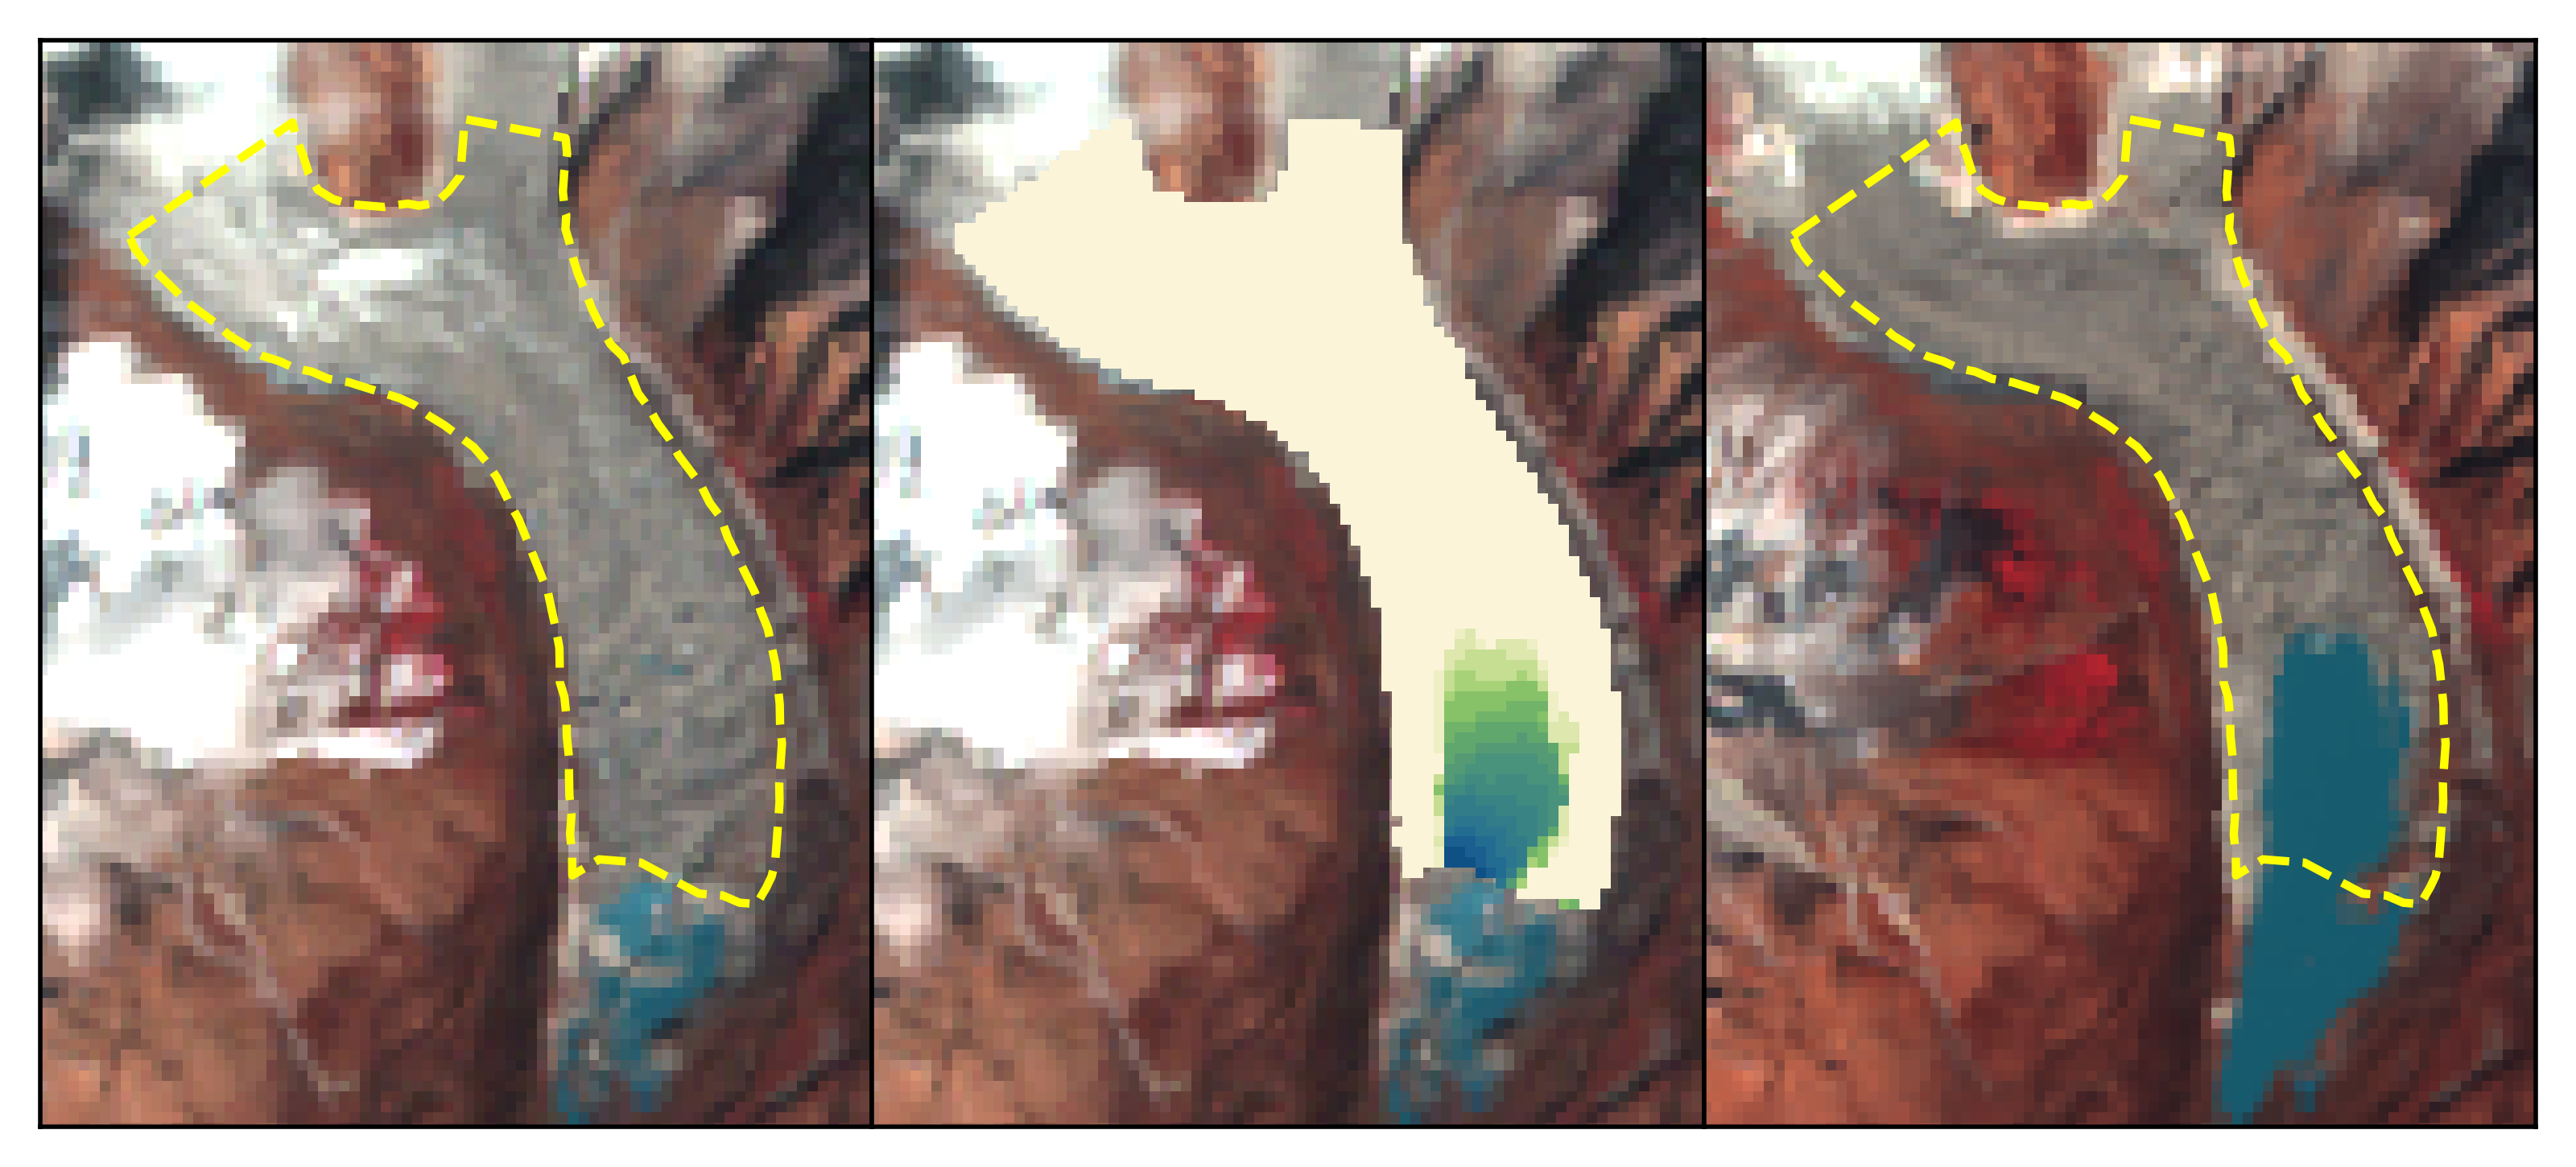

In [75]:
# Bechung glacier
rgi_id_g = "RGI2000-v7.0-G-15-09530" #
glacier_name = ""
rgi_id,gname,xr_water,xr_mask,geom,lonlat,g_gdf = get_single_glacier(rgi_id_g, glacier_name)

y1 = 2004
y2 = 2023

all_freq = xr_water.sel(year=slice(y1,y2))
all_freq = all_freq.mean(dim='year')

bounds_y = all_freq.y.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='x').values > 0 ]
bounds_x = all_freq.x.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='y').values > 0 ]
cmap=cm.navia_r

# make zeros nan
# all_freq = all_freq.where(all_freq>0, np.nan)

### load images locally with xarray
g_fc = geemap.geopandas_to_ee(g_gdf)
im1 = LS_ic.filterDate("2003-12-04","2003-12-05").filterBounds(g_fc).first().select(["NIR","Red","Green"])
im2 = LS_ic.filterDate("2023-11-25","2023-11-26").filterBounds(g_fc).first().select(["NIR","Red","Green"])

# first define the buffer around our glacier
g_bounds = ee.Feature(g_fc.first()).bounds().buffer(3000).bounds()

# then clip to this and load
ds1 = xr.open_dataset(ee.ImageCollection(im1.clip(g_bounds)), engine='ee', projection=proj_esri102025)

# reformat to how we want it to be 
im1_xr = xr.concat([ds1['NIR'].squeeze(), ds1['Red'].squeeze(), ds1['Green'].squeeze()], dim='band')

# repeat for the 2nd image
ds2 = xr.open_dataset(ee.ImageCollection(im2.clip(g_bounds)), engine='ee', projection=proj_esri102025)
im2_xr = xr.concat([ds2['NIR'].squeeze(), ds2['Red'].squeeze(), ds2['Green'].squeeze()], dim='band')
print("Loaded")

### make figure
fig,axs = plt.subplots(1,3, figsize=(6.5,3), dpi=500)

# pre-image
im1_xr.plot.imshow(ax=axs[0], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[0], color='yellow', linestyle='dashed')

# plot the SGL frequency
im1_xr.plot.imshow(ax=axs[1], x='X', y='Y', vmin=0, vmax=0.4)
all_freq.plot(ax=axs[1], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)

# post-image
im2_xr.plot.imshow(ax=axs[2], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[2], color='yellow', linestyle='dashed')

# post-image

for ax in axs:
    ax.axis('equal')
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(min(bounds_x)-60, max(bounds_x)+60)
    ax.set_ylim(min(bounds_y)-400, max(bounds_y)+0)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(w_pad=0)

save = 1
name = f"{gname}-{rgi_id}-{y1}{y2}"
out_path = os.path.join(folder_HMA, 'Figures', 'examples', f"{name}.png")

if save:
    plt.savefig(out_path,transparent=True, dpi=500, bbox_inches='tight')

Loaded


C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


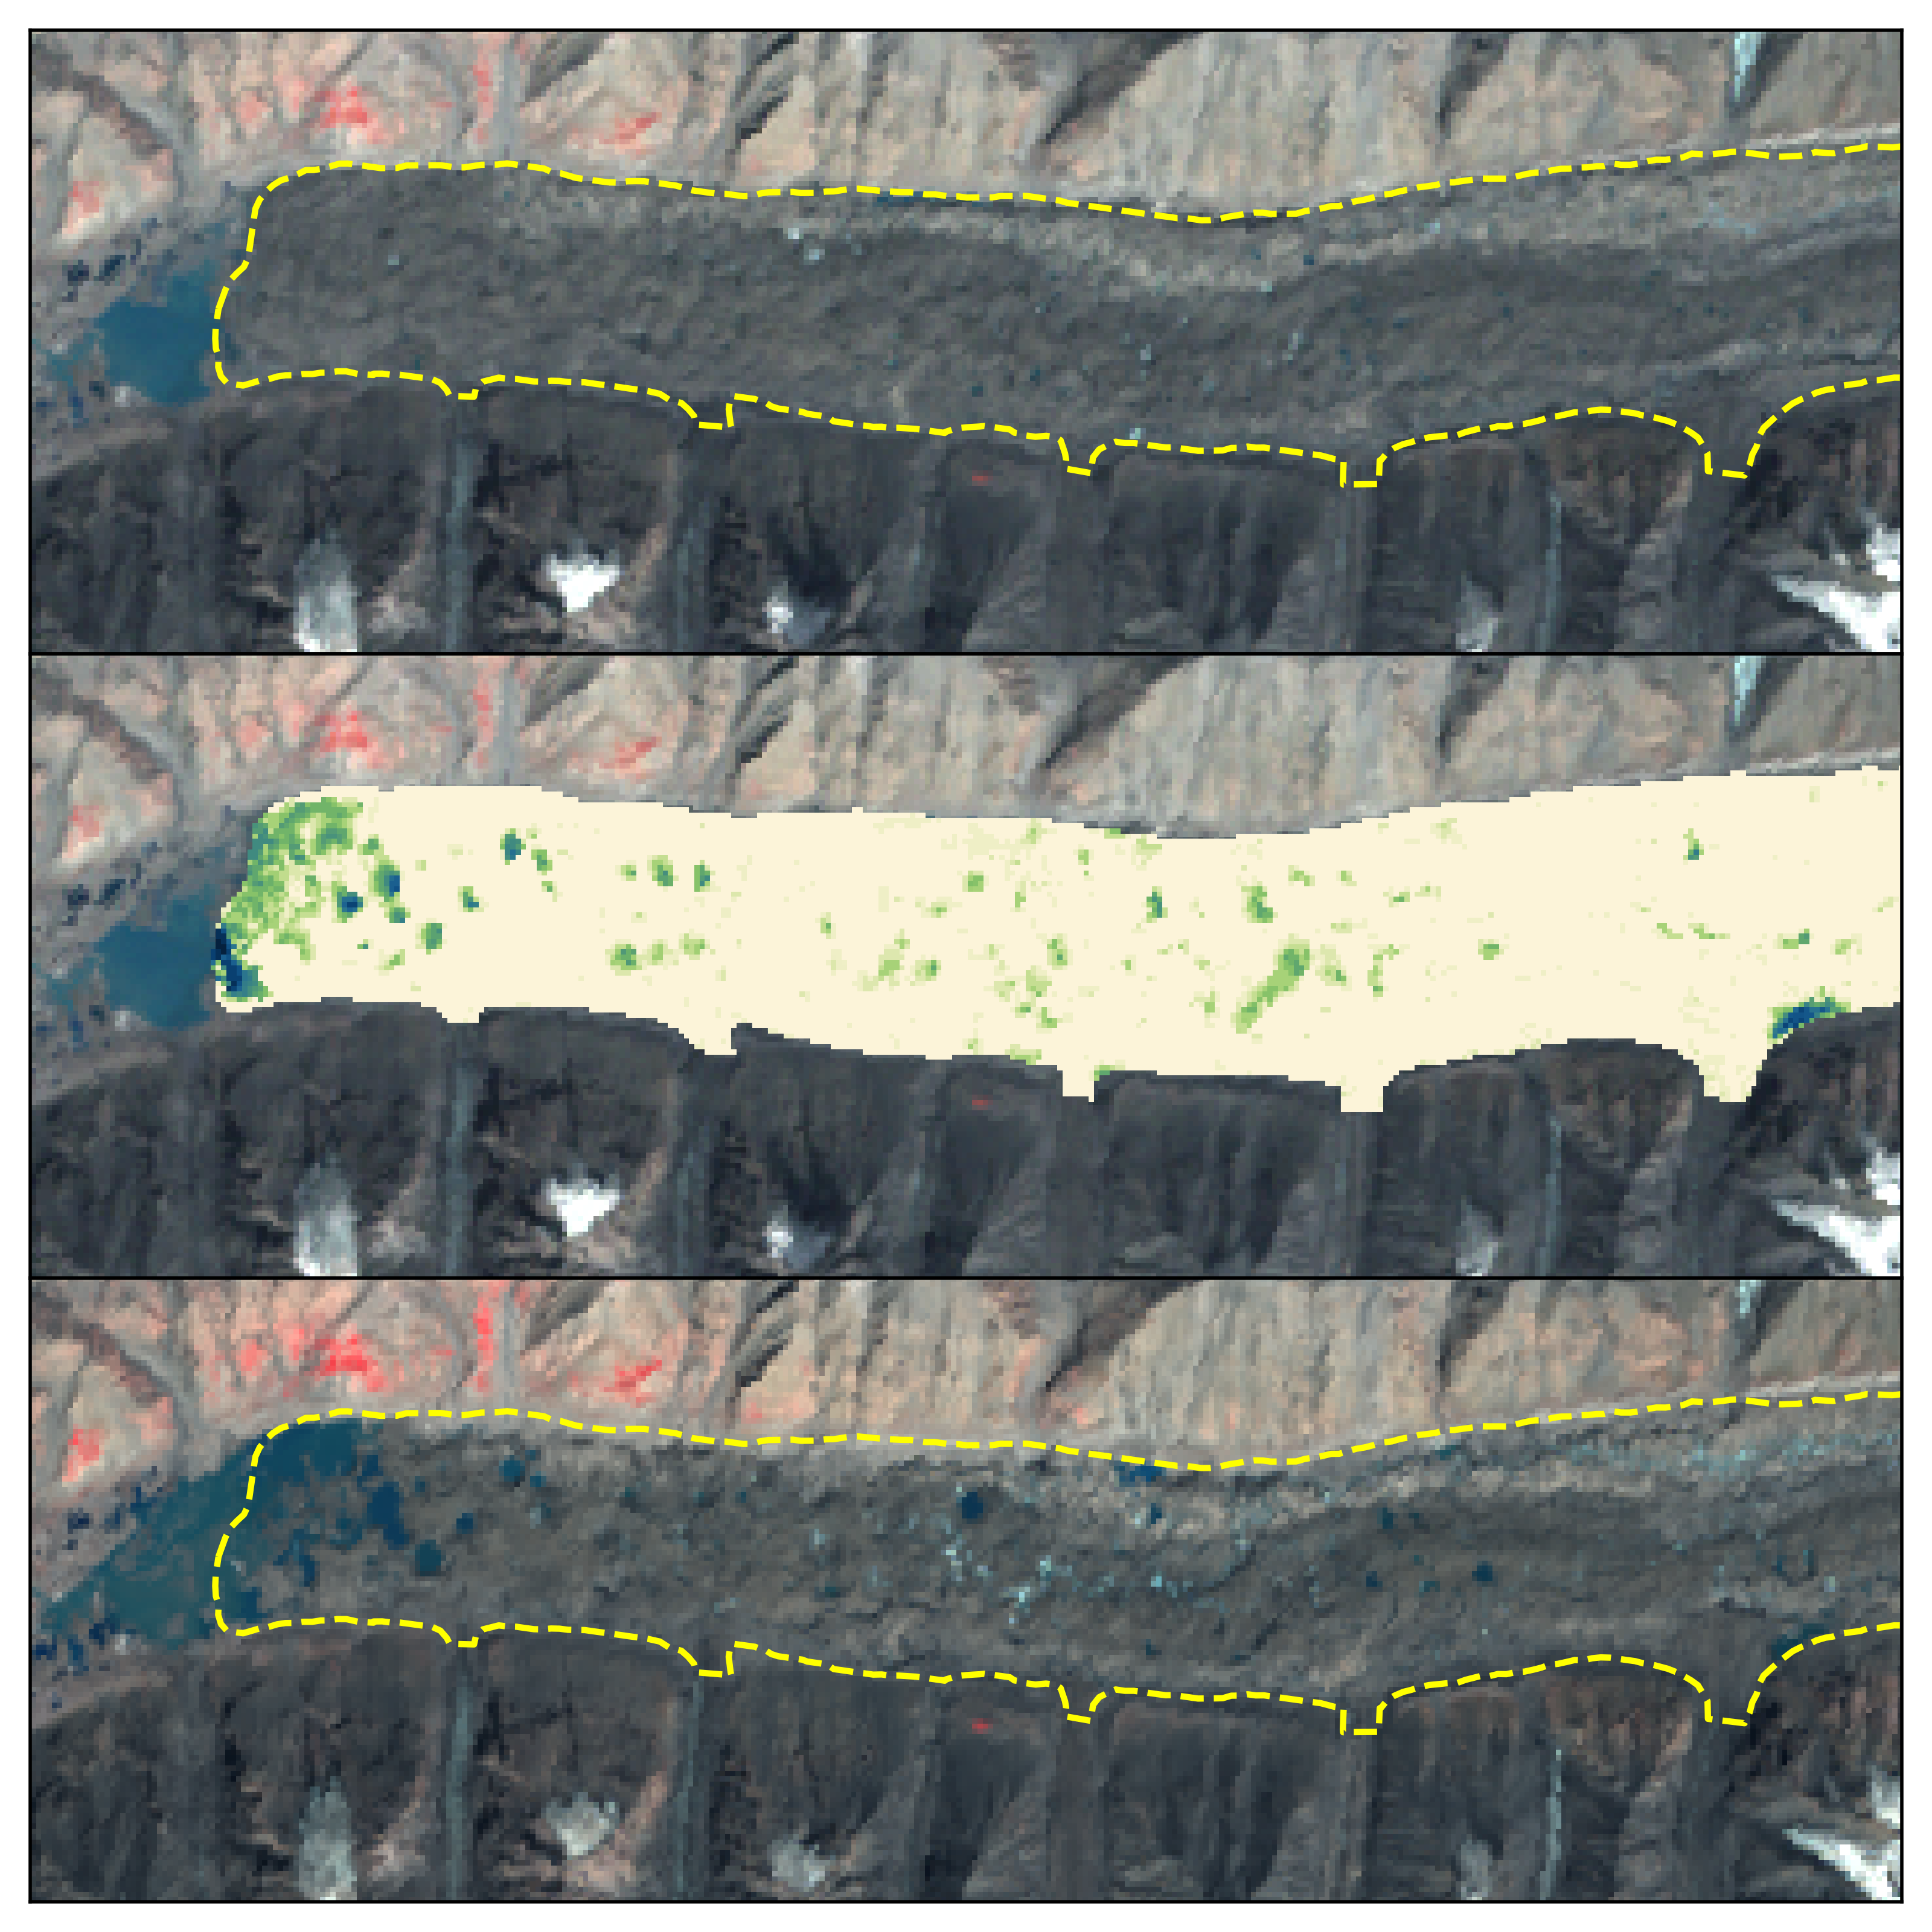

In [71]:
# south engilchek glacier
rgi_id_g = "RGI2000-v7.0-G-13-27528" #
glacier_name = ""
rgi_id,gname,xr_water,xr_mask,geom,lonlat,g_gdf = get_single_glacier(rgi_id_g, glacier_name)

y1 = 2004
y2 = 2023

all_freq = xr_water.sel(year=slice(y1,y2))
all_freq = all_freq.mean(dim='year')

bounds_y = all_freq.y.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='x').values > 0 ]
bounds_x = all_freq.x.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='y').values > 0 ]
cmap=cm.navia_r

# make zeros nan
# all_freq = all_freq.where(all_freq>0, np.nan)

### load images locally with xarray
g_fc = geemap.geopandas_to_ee(g_gdf)
im1 = LS_ic.filterDate("2006-08-20","2006-08-22").filterBounds(g_fc).first().select(["NIR","Red","Green"])
im2 = LS_ic.filterDate("2023-08-03","2023-08-05").filterBounds(g_fc).first().select(["NIR","Red","Green"])

# first define the buffer around our glacier
g_bounds = ee.Feature(g_fc.first()).bounds().buffer(3000).bounds()

# then clip to this and load
ds1 = xr.open_dataset(ee.ImageCollection(im1.clip(g_bounds)), engine='ee', projection=proj_esri102025)

# reformat to how we want it to be 
im1_xr = xr.concat([ds1['NIR'].squeeze(), ds1['Red'].squeeze(), ds1['Green'].squeeze()], dim='band')

# repeat for the 2nd image
ds2 = xr.open_dataset(ee.ImageCollection(im2.clip(g_bounds)), engine='ee', projection=proj_esri102025)
im2_xr = xr.concat([ds2['NIR'].squeeze(), ds2['Red'].squeeze(), ds2['Green'].squeeze()], dim='band')
print("Loaded")

### make figure
fig,axs = plt.subplots(3,1, figsize=(6.5,6.5), dpi=500)

# pre-image
im1_xr.plot.imshow(ax=axs[0], x='X', y='Y', vmin=0, vmax=0.3)
g_gdf.exterior.plot(ax=axs[0], color='yellow', linestyle='dashed')

# plot the SGL frequency
im1_xr.plot.imshow(ax=axs[1], x='X', y='Y', vmin=0, vmax=0.3)
all_freq.plot(ax=axs[1], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)

# post-image
im2_xr.plot.imshow(ax=axs[2], x='X', y='Y', vmin=0, vmax=0.3)
g_gdf.exterior.plot(ax=axs[2], color='yellow', linestyle='dashed')

# post-image

for ax in axs:
    ax.axis('equal')
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(min(bounds_x)-150, max(bounds_x)-8000)
    ax.set_ylim(min(bounds_y)-50, max(bounds_y)+250)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(w_pad=0, h_pad=0)

save = 1
name = f"{gname}-{rgi_id}-{y1}{y2}"
out_path = os.path.join(folder_HMA, 'Figures', 'examples', f"{name}.png")

if save:
    plt.savefig(out_path, transparent=True, dpi=500, bbox_inches='tight')

Loaded


C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


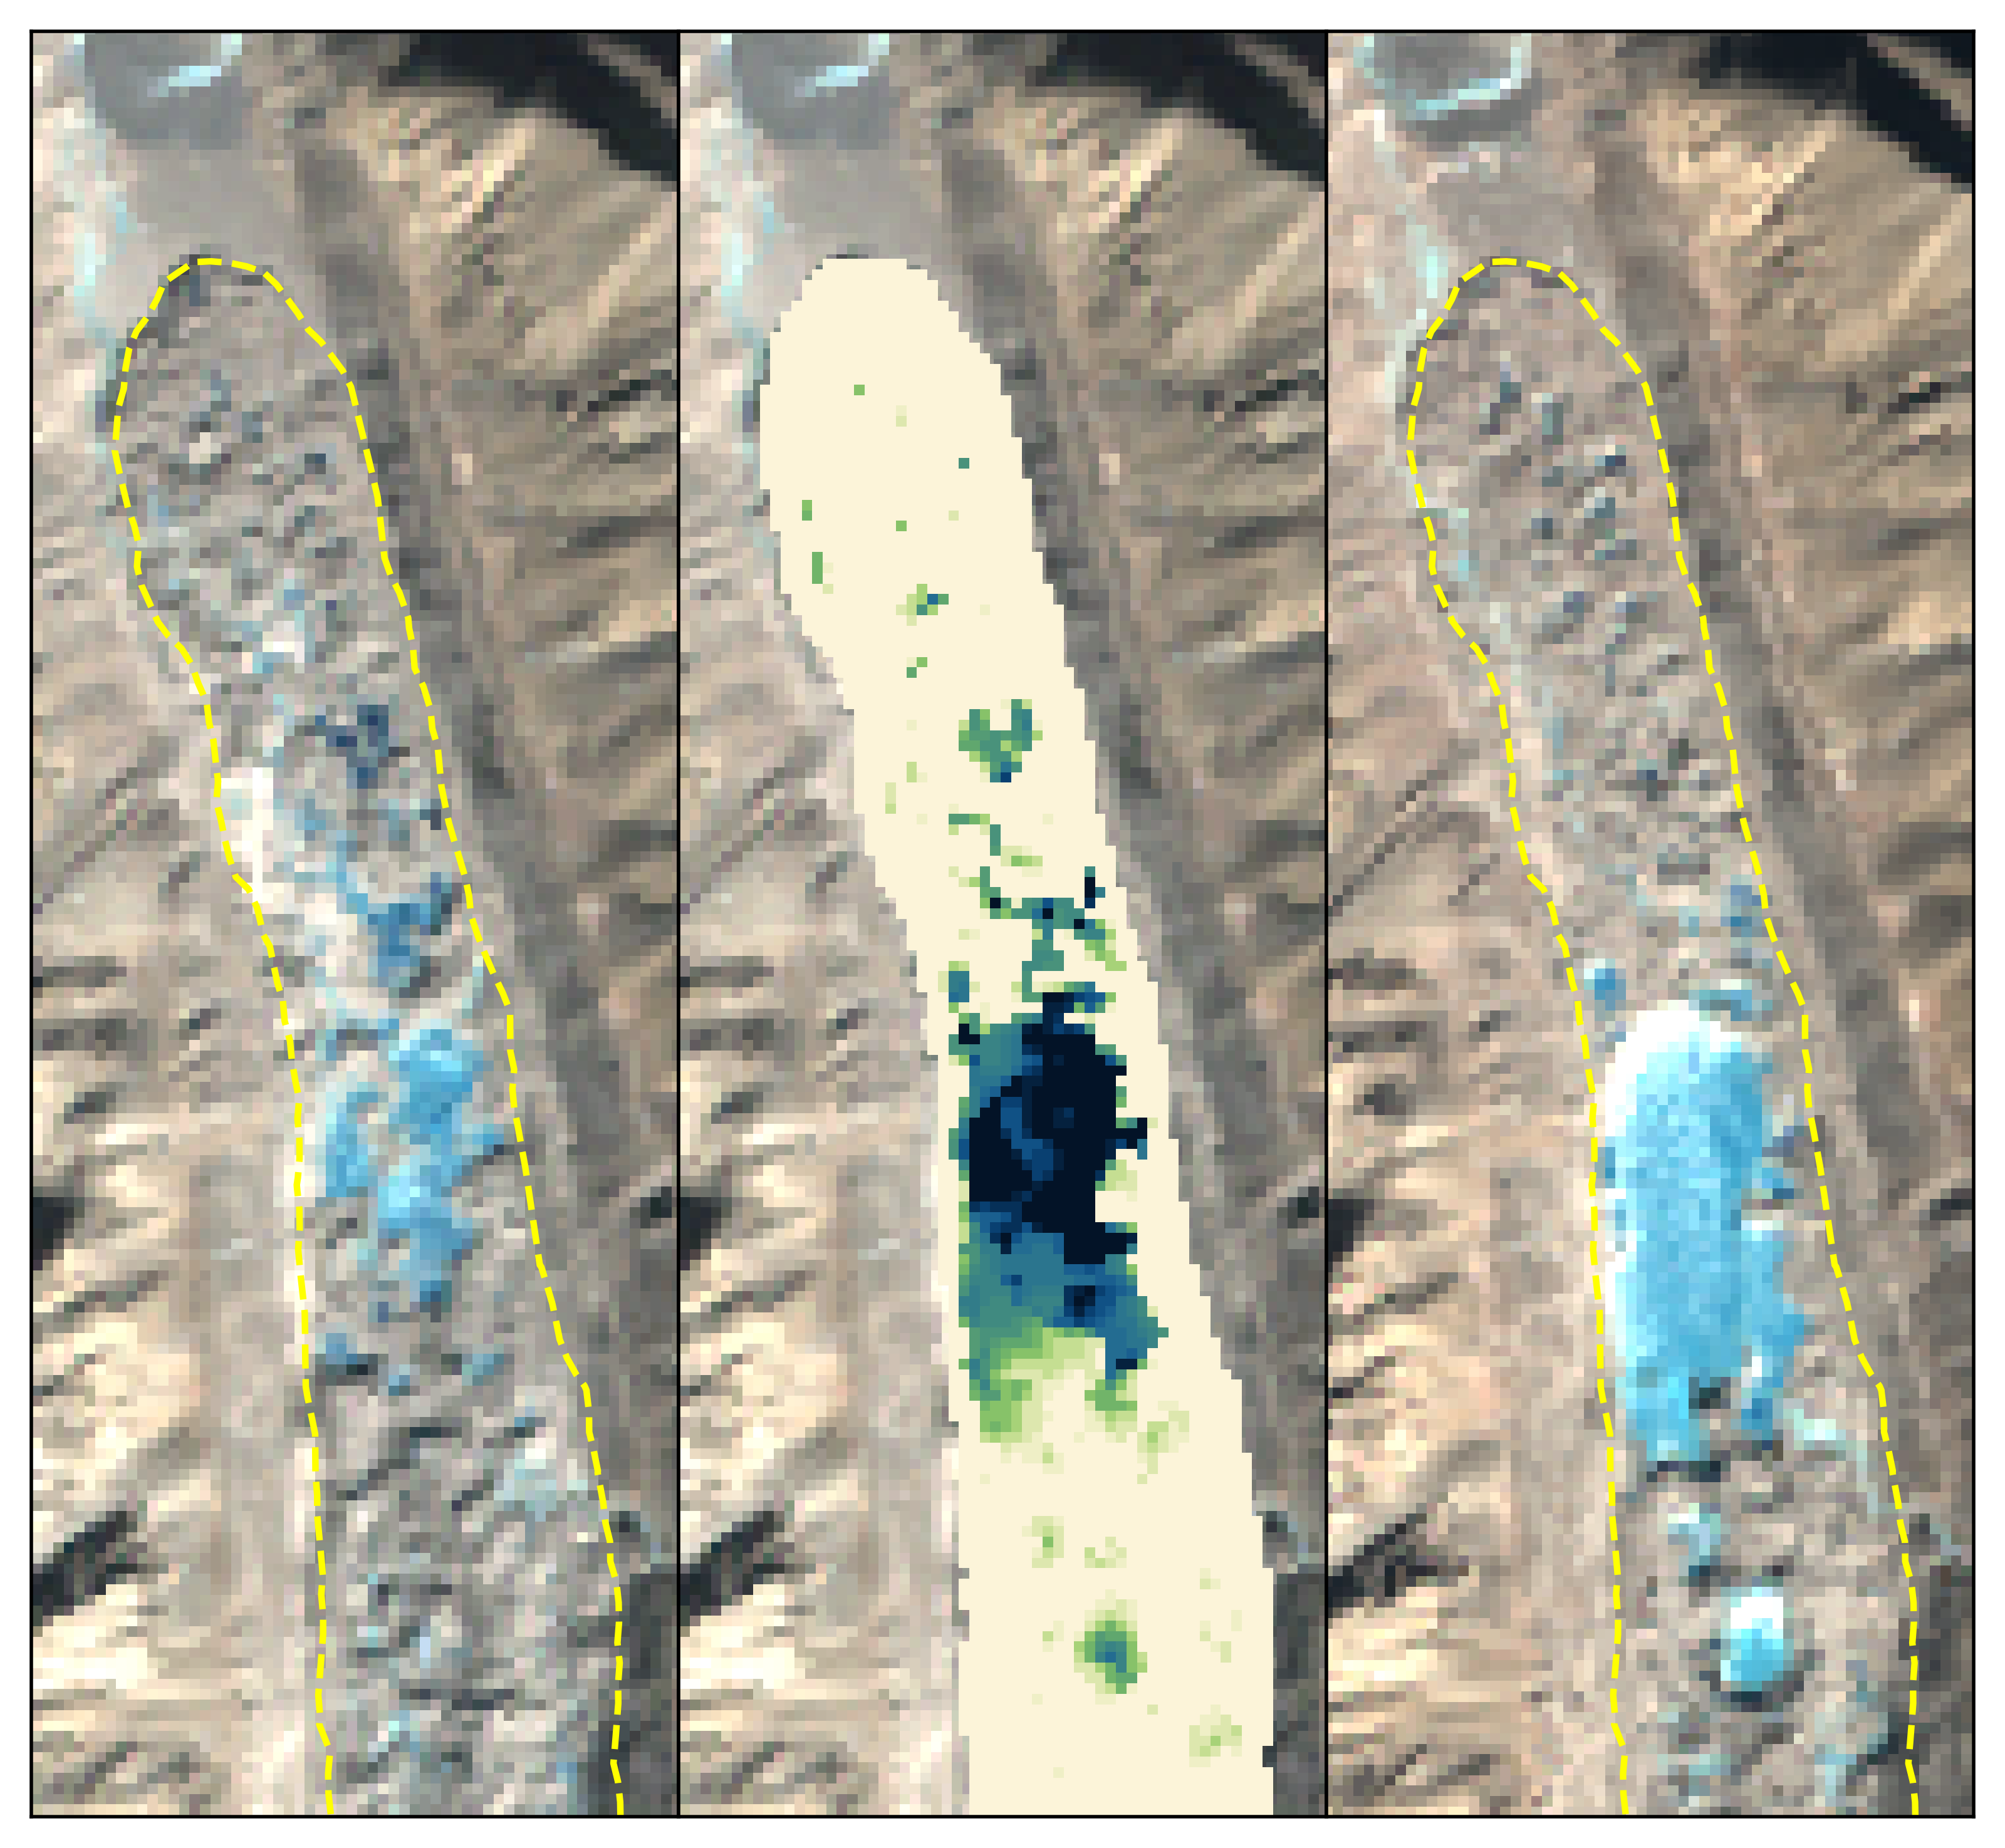

In [65]:
# Rongbuk glacier
rgi_id_g = "RGI2000-v7.0-G-15-08313" #
glacier_name = ""
rgi_id,gname,xr_water,xr_mask,geom,lonlat,g_gdf = get_single_glacier(rgi_id_g, glacier_name)

y1 = 2004
y2 = 2023

all_freq = xr_water.sel(year=slice(y1,y2))
all_freq = all_freq.mean(dim='year')

bounds_y = all_freq.y.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='x').values > 0 ]
bounds_x = all_freq.x.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='y').values > 0 ]
cmap=cm.navia_r

### load images locally with xarray
g_fc = geemap.geopandas_to_ee(g_gdf)
im1 = LS_ic.filterDate("2003-12-17","2003-12-19").filterBounds(g_fc).first().select(["NIR","Red","Green"])
im2 = LS_ic.filterDate("2023-12-17","2023-12-19").filterBounds(g_fc).first().select(["NIR","Red","Green"])

# first define the buffer around our glacier
g_bounds = ee.Feature(g_fc.first()).bounds().buffer(3000).bounds()

# then clip to this and load
ds1 = xr.open_dataset(ee.ImageCollection(im1.clip(g_bounds)), engine='ee', projection=proj_esri102025)

# reformat to how we want it to be 
im1_xr = xr.concat([ds1['NIR'].squeeze(), ds1['Red'].squeeze(), ds1['Green'].squeeze()], dim='band')

# repeat for the 2nd image
ds2 = xr.open_dataset(ee.ImageCollection(im2.clip(g_bounds)), engine='ee', projection=proj_esri102025)
im2_xr = xr.concat([ds2['NIR'].squeeze(), ds2['Red'].squeeze(), ds2['Green'].squeeze()], dim='band')
print("Loaded")

### make figure
fig,axs = plt.subplots(1,3, figsize=(6.5,6), dpi=500)

# pre-image
im1_xr.plot.imshow(ax=axs[0], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[0], color='yellow', linestyle='dashed')

# plot the SGL frequency
im1_xr.plot.imshow(ax=axs[1], x='X', y='Y', vmin=0, vmax=0.4)
all_freq.plot(ax=axs[1], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)

# post-image
im2_xr.plot.imshow(ax=axs[2], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[2], color='yellow', linestyle='dashed')

# post-image

for ax in axs:
    ax.axis('equal')
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(min(bounds_x)+7000, max(bounds_x)+60)
    ax.set_ylim(min(bounds_y)+6000, max(bounds_y)+60)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(w_pad=0)

save = 1
name = f"{gname}-{rgi_id}-{y1}{y2}"
out_path = os.path.join(folder_HMA, 'Figures', 'examples', f"{name}.png")

if save:
    plt.savefig(out_path,transparent=True, dpi=500, bbox_inches='tight')

Loaded


C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\lzell\anaconda3\envs\hma_env\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


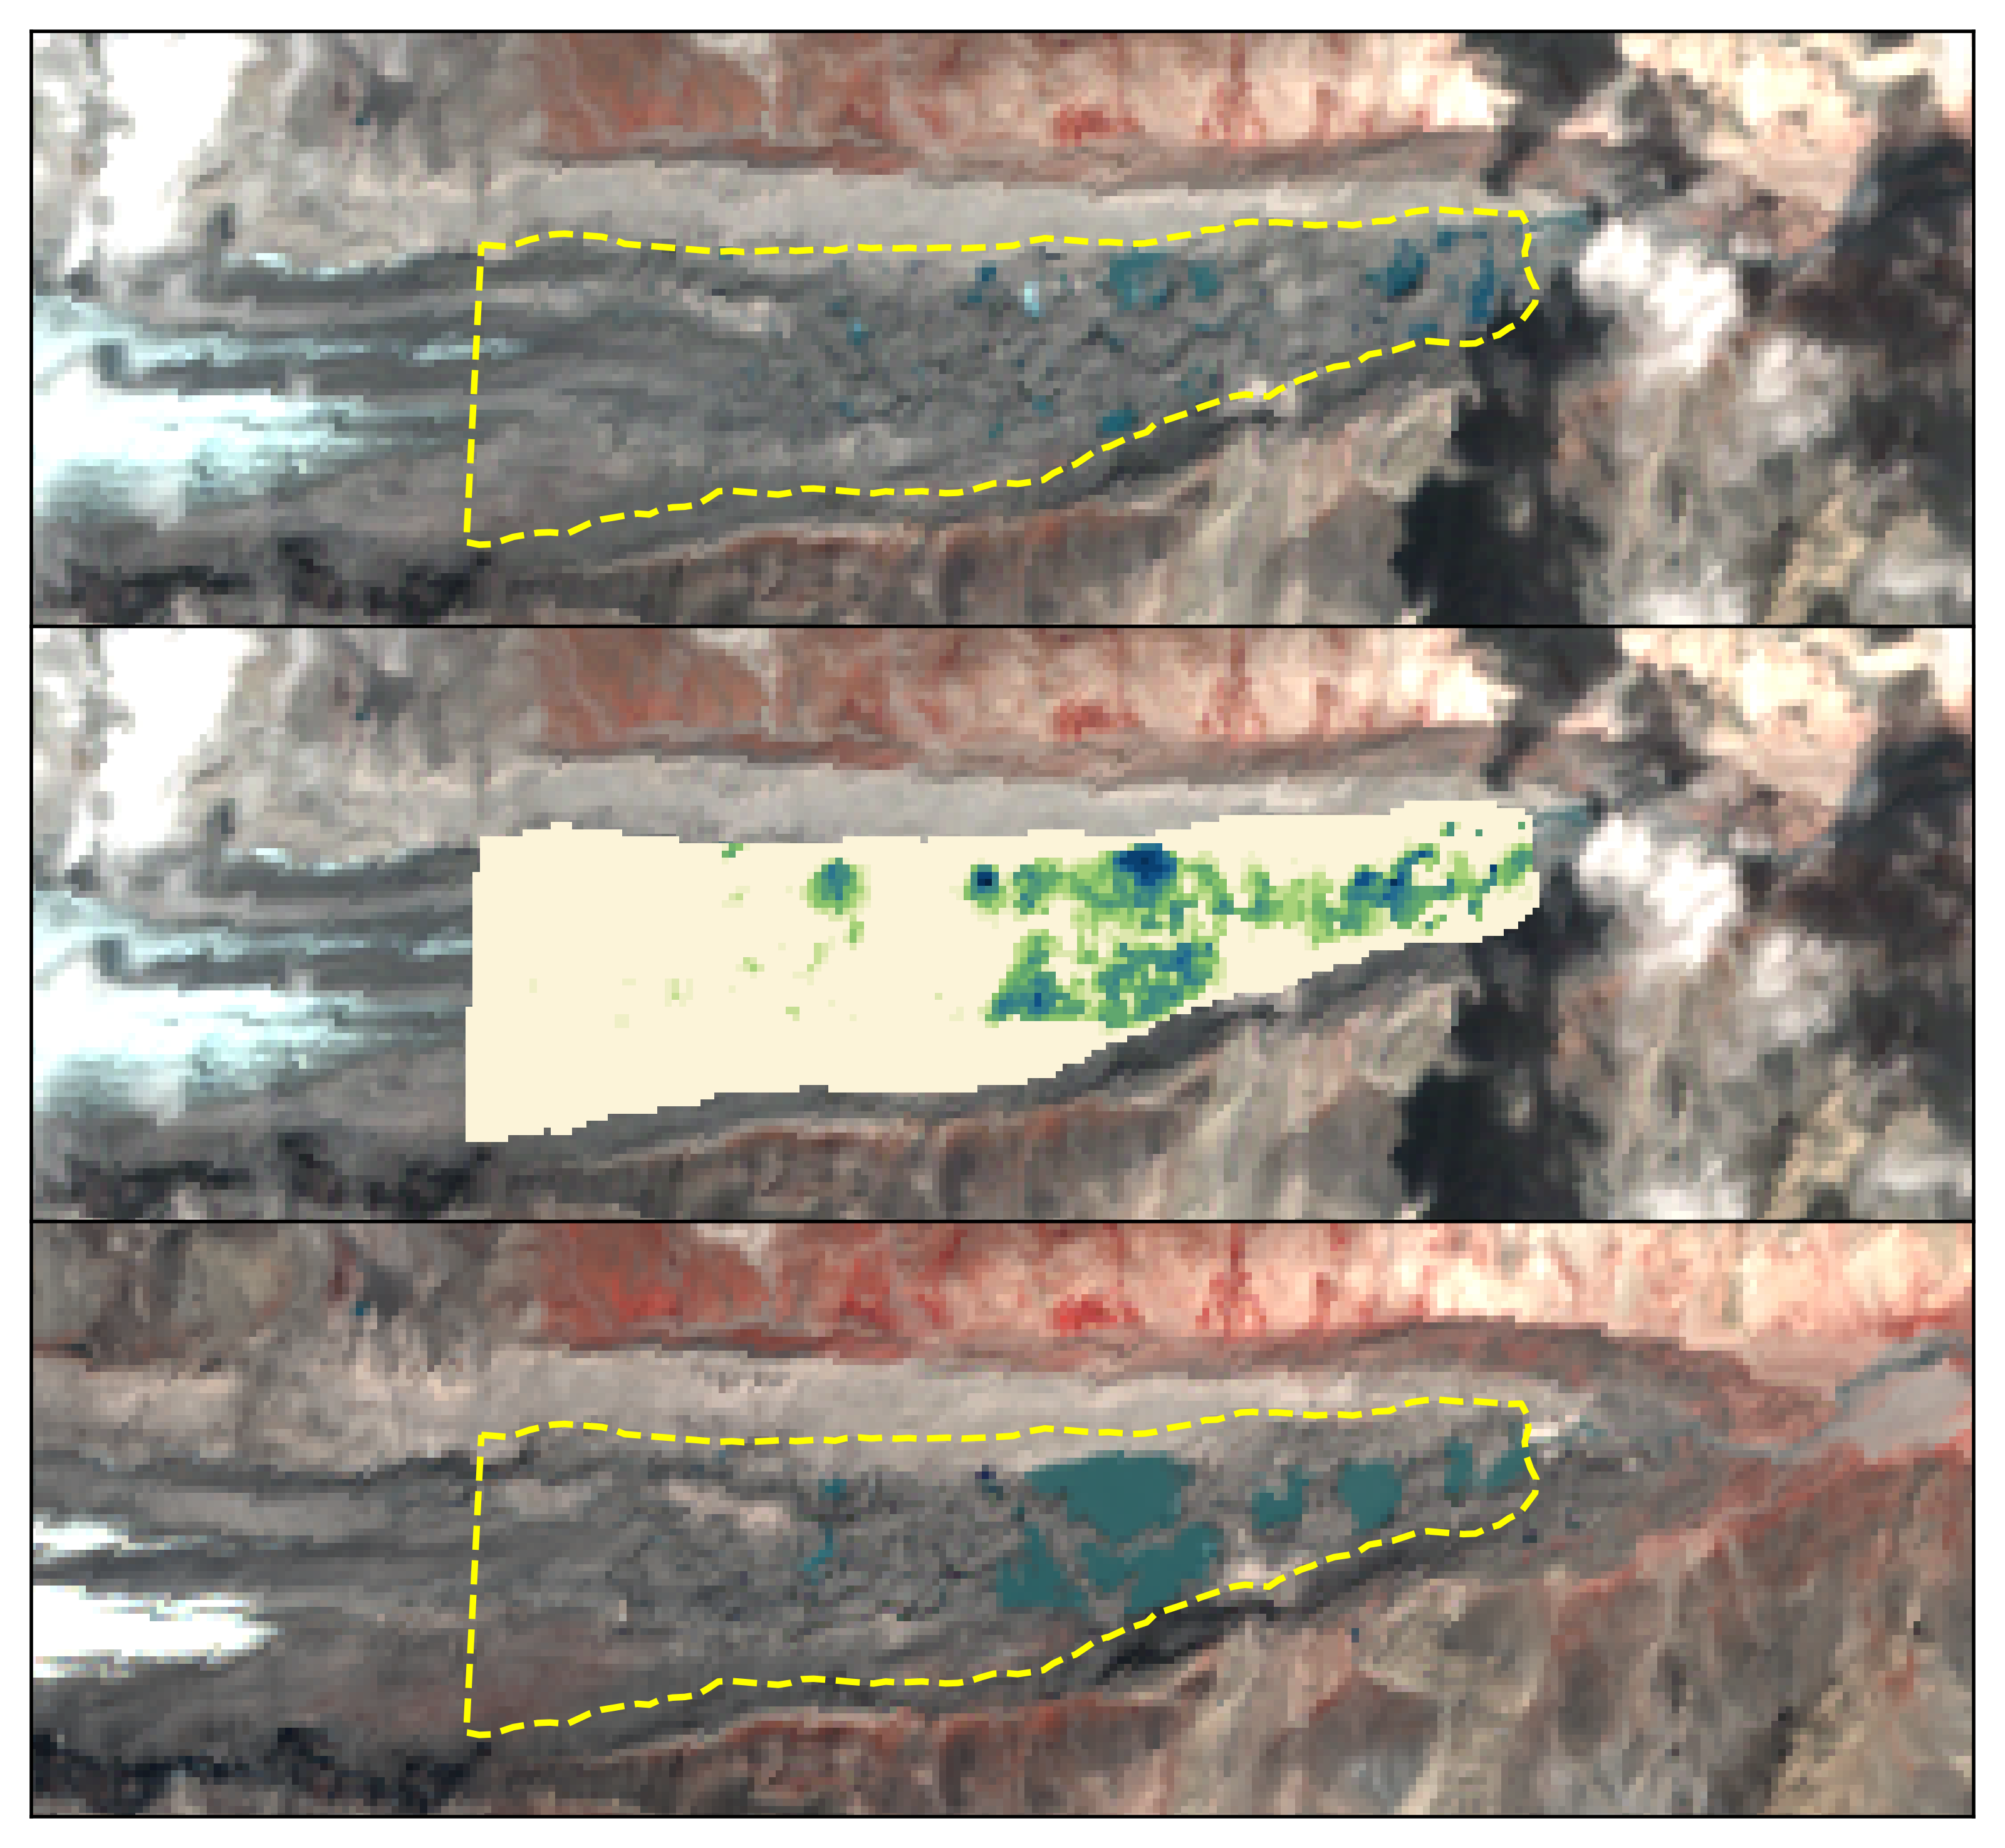

In [69]:
# unnamed glacier
rgi_id_g = "RGI2000-v7.0-G-15-08596" #
glacier_name = ""
rgi_id,gname,xr_water,xr_mask,geom,lonlat,g_gdf = get_single_glacier(rgi_id_g, glacier_name)

y1 = 2004
y2 = 2023

all_freq = xr_water.sel(year=slice(y1,y2))
all_freq = all_freq.mean(dim='year')

bounds_y = all_freq.y.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='x').values > 0 ]
bounds_x = all_freq.x.values[ xr.where(~np.isnan(all_freq), 1, 0).sum(dim='y').values > 0 ]
cmap=cm.navia_r

### load images locally with xarray
g_fc = geemap.geopandas_to_ee(g_gdf)
im1 = LS_ic.filterDate("2005-10-04","2005-10-05").filterBounds(g_fc).first().select(["NIR","Red","Green"])
im2 = LS_ic.filterDate("2023-10-06","2023-10-07").filterBounds(g_fc).first().select(["NIR","Red","Green"])

# first define the buffer around our glacier
g_bounds = ee.Feature(g_fc.first()).bounds().buffer(3000).bounds()

# then clip to this and load
ds1 = xr.open_dataset(ee.ImageCollection(im1.clip(g_bounds)), engine='ee', projection=proj_esri102025)

# reformat to how we want it to be 
im1_xr = xr.concat([ds1['NIR'].squeeze(), ds1['Red'].squeeze(), ds1['Green'].squeeze()], dim='band')

# repeat for the 2nd image
ds2 = xr.open_dataset(ee.ImageCollection(im2.clip(g_bounds)), engine='ee', projection=proj_esri102025)
im2_xr = xr.concat([ds2['NIR'].squeeze(), ds2['Red'].squeeze(), ds2['Green'].squeeze()], dim='band')
print("Loaded")

### make figure
fig,axs = plt.subplots(3,1, figsize=(6.5,6), dpi=500)

# pre-image
im1_xr.plot.imshow(ax=axs[0], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[0], color='yellow', linestyle='dashed')

# plot the SGL frequency
im1_xr.plot.imshow(ax=axs[1], x='X', y='Y', vmin=0, vmax=0.4)
all_freq.plot(ax=axs[1], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)

# post-image
im2_xr.plot.imshow(ax=axs[2], x='X', y='Y', vmin=0, vmax=0.4)
g_gdf.exterior.plot(ax=axs[2], color='yellow', linestyle='dashed')

# post-image

for ax in axs:
    ax.axis('equal')
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(min(bounds_x)-600, max(bounds_x)+600)
    ax.set_ylim(min(bounds_y)-200, max(bounds_y)+600)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(w_pad=0, h_pad=0)

save = 1
name = f"{gname}-{rgi_id}-{y1}{y2}"
out_path = os.path.join(folder_HMA, 'Figures', 'examples', f"{name}.png")

if save:
    plt.savefig(out_path,transparent=True, dpi=500, bbox_inches='tight')